# Amhdal's Law Scaling Charts 

# Charts for AMD TrPro Zen4 vs Xeon-w
# HPL, HPCG, HPL-MxP (HPL-AI), OpenFOAM

Testing using 
- Intel OneAPI MKL benchmarks  [https://hub.docker.com/r/intel/hpckit/tags](https://hub.docker.com/r/intel/hpckit/tags)
- docker pull intel/hpckit:2024.0.1-devel-ubuntu22.04
- NS=114560 (80% mem on 128GB sys)
- AMD  Optimized Zen4 [https://www.amd.com/en/developer/zen-software-studio/applications/pre-built-applications.html](https://www.amd.com/en/developer/zen-software-studio/applications/pre-built-applications.html)
- amd-zen-hpl-2023_07_18.tar.gz
- amd-zen-hpl-mxp-2022_12.tar.gz
- amd-zen-hpcg-2022_11.tar.gz
- OpenFOAM [https://www.openfoam.com/current-release](https://www.openfoam.com/current-release)
-  OpenFOAM-v2312, was released on 22/12/2023.
-  https://develop.openfoam.com/Development/openfoam/-/wikis/precompiled/docker

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
sns.set() # not using seaborn but this makes the plots look better
%matplotlib inline

import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Workaround for plotly not reading PS logo image
from PIL import Image

# Open the image file
img = Image.open("PugetSystems_Logo_RGB_1.resized.png")

## HPL Scaling -- Optimized binaries from AMD and Intel

In [50]:
# These are the run times
hpl7995 = np.array([12276,6195,3139,1625,871.6,584.1,462.8,344.2,314.1,290.6,239.2])
hpl7995 = hpl7995[0]/hpl7995
print(hpl7995)

hpl7985 = np.array([12271,6188,3124,1610,867.7,581.5,457.4,338.8,316.0,289.0])
hpl7985 = hpl7985[0]/hpl7985
print(hpl7985)

hpl3495 = np.array([8806,4467,2251,1184,677,472,421.8,359,337])
hpl3495 = hpl3495[0]/hpl3495
print(hpl3495)

hpl7980 = np.array([12184,6215,3170,1618,872.2,580.2,714.2,347.2,320.8,297.1])
hpl7980 = hpl7980[0]/hpl7980
print(hpl7980)

[ 1.          1.98159806  3.91079962  7.55446154 14.0844424  21.01694915
 26.52549697 35.66531087 39.08309456 42.24363386 51.32107023]
[ 1.          1.98303167  3.92797695  7.62173913 14.14198456 21.10232158
 26.82772191 36.21900826 38.83227848 42.46020761]
[ 1.          1.97134542  3.91203909  7.4375     13.00738552 18.65677966
 20.87719298 24.52924791 26.1305638 ]
[ 1.          1.96041834  3.84353312  7.5302843  13.9692731  20.99965529
 17.05964716 35.0921659  37.98004988 41.00976102]


In [51]:
ncores7995 = np.array([1,2,4,8,16,24,32,48,56,64,96])
ncores7985 = ncores7995[:10]
ncores3495 = np.array([1,2,4,8,16,32,40,48,56])
ncores7980 = ncores7995[:10]


This is Amdhal's Law equation that I will "fit" the data to.

In [52]:
def amdhal(n,P,base):
    return base/((1-P)+(P/n))

This is the curve fit. Really easy using scipy!
popt is the optimized parameter P and pcov is the covarience which is just a statistics measure that I don't need but I need a variable for it since it is part of the output from that command.

The lambda is to preserve the expected function signature for cure_fit

In [53]:

popt7995, pcov = curve_fit(lambda n,P: amdhal(n,P,hpl7995[0]), ncores7995, hpl7995)
print(popt7995)

popt7985, pcov = curve_fit(lambda n,P: amdhal(n,P,hpl7985[0]), ncores7985, hpl7985)
print(popt7985)

popt3495, pcov = curve_fit(lambda n,P: amdhal(n,P,hpl3495[0]), ncores3495, hpl3495)
print(popt3495)

popt7980, pcov = curve_fit(lambda n,P: amdhal(n,P,hpl7980[0]), ncores7980, hpl7980)
print(popt7980)

[0.9914965]
[0.9923184]
[0.97869792]
[0.99069152]


(20,)


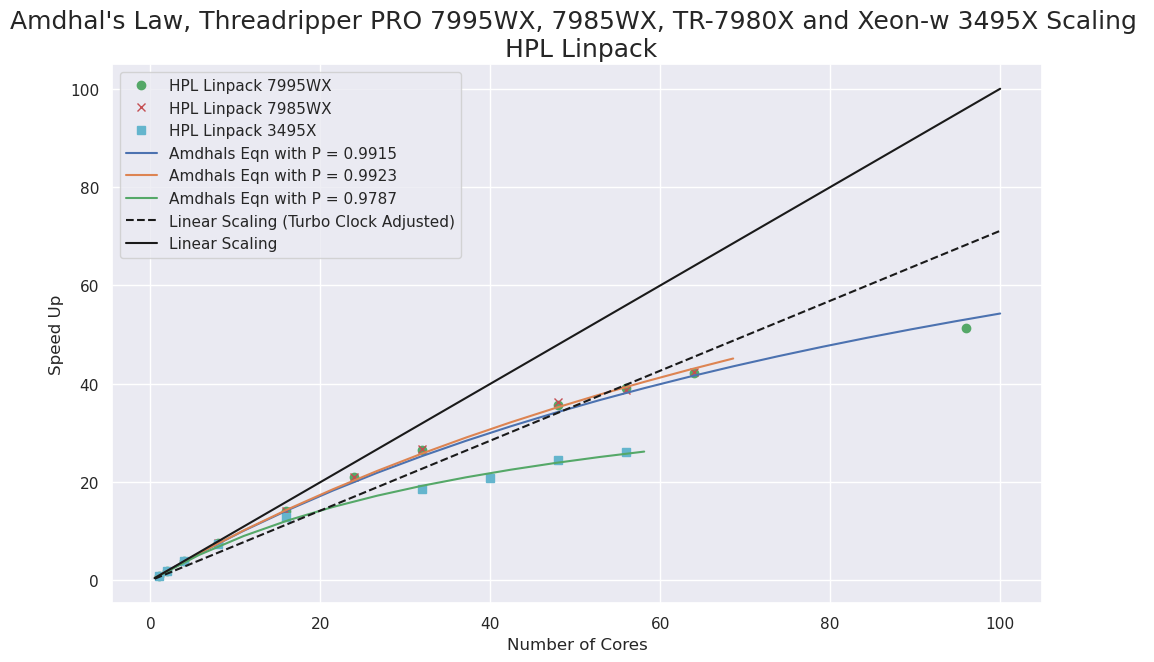

In [55]:
plt.rcParams["figure.figsize"] = [12,7]
#plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
ax.plot( ncores7995, hpl7995, "o", color='g', label='HPL Linpack 7995WX')  # plot the test data
ax.plot( ncores7985, hpl7985, "x", color='r', label='HPL Linpack 7985WX') 
#ax.plot( ncores7980, hpl7980, "d", color='r', label='HPL Linpack 7980X') 
ax.plot( ncores3495, hpl3495, "s", color='c', label='HPL Linpack 3495X') 

xt = np.linspace(0.5,100,20)
print(xt.shape)

ax.plot(xt, amdhal(xt,popt7995,hpl7995[0])  ,  label='Amdhals Eqn with P = %.4f ' %(popt7995[0]))  # plot the model function
ax.plot(xt[:14], amdhal(xt[:14],popt7985,hpl7985[0])  ,  label='Amdhals Eqn with P = %.4f ' %(popt7985[0]))
#ax.plot(xt[:14], amdhal(xt[:14],popt7980,hpl7980[0])  ,  label='Amdhals Eqn with P = %.4f ' %(popt7980[0]))
ax.plot(xt[:12], amdhal(xt[:12],popt3495,hpl3495[0])  ,  label='Amdhals Eqn with P = %.4f ' %(popt3495[0]))

slope=3.2/4.5
ax.plot(xt,slope*xt, "--", color='k', label='Linear Scaling (Turbo Clock Adjusted)')
ax.plot(xt,hpl7995[0]*xt, color='k', label='Linear Scaling')

plt.xlabel("Number of Cores")
plt.ylabel("Speed Up")
plt.title("Amdhal's Law, Threadripper PRO 7995WX, 7985WX, and Xeon-w 3495X Scaling \n HPL Linpack", fontsize=18)
ax.legend()

fig.savefig('hpl-scaling.png')

## HPL Bar Chart

In [72]:
dfhpl = pd.DataFrame({'CPU':[
    'TrPro 7995WX 96-core',
    'TrPro 7985WX 64-core',
    'Xeon w9-3495 56-core',
    'TrPro 5995WX 64-core',
     ], 
    'GFLOP/s':[4189, 3469, 2972, 1856 ]})
dfhpl

,CPU,GFLOP/s
0,TrPro 7995WX 96-core,4189
1,TrPro 7985WX 64-core,3469
2,Xeon w9-3495 56-core,2972
3,TrPro 5995WX 64-core,1856


In [73]:
def plot_bar(x,y,title,perf_unit,xtitle):
    fig = go.Figure()


    p_blue='#163AD6'
    p_green='#08CC96'
    p_lblue='#3E7AFF'
    colors=[p_blue,p_blue,p_blue,p_green,p_lblue]
    
    marker_color=colors

    fig.add_trace( go.Bar(
        x=x, y=y, orientation='h',
        text=x, textposition="auto",
        marker_color=colors,
        #width=.4
                )
    )

    fig.update_layout(
        title=dict(
            text=f"{title}{perf_unit}" ,
            x=0.5,y=0.90,
            xanchor='center',
            yanchor='top',
            font=dict(size=20),
            font_family="Poppins",
        ),
        bargap=0.35,
        font_family="Roboto",
        font_size=10.5,
        xaxis=dict(title=xtitle),
        #yaxis={'catagoryorder':'title:assending'},
        yaxis={'categoryorder':'array', 'categoryarray':[ 'TrPro 5995WX 64-core','Xeon w9-3495 56-core','TrPro 7985WX 64-core','TrPro 7995WX 96-core',]},
        template="plotly_white",

        autosize=True,
        width=800,
        height=520,

    )

    fig.add_layout_image(
        dict(
            source=img, #"./PugetSystems_Logo_RGB_1.resized.png",
            xref="paper", yref="paper",
            x=0.5, y=-.15,
            sizex=0.35, sizey=0.35,
            xanchor="center", yanchor="top"
            )
    )

    fig.show()

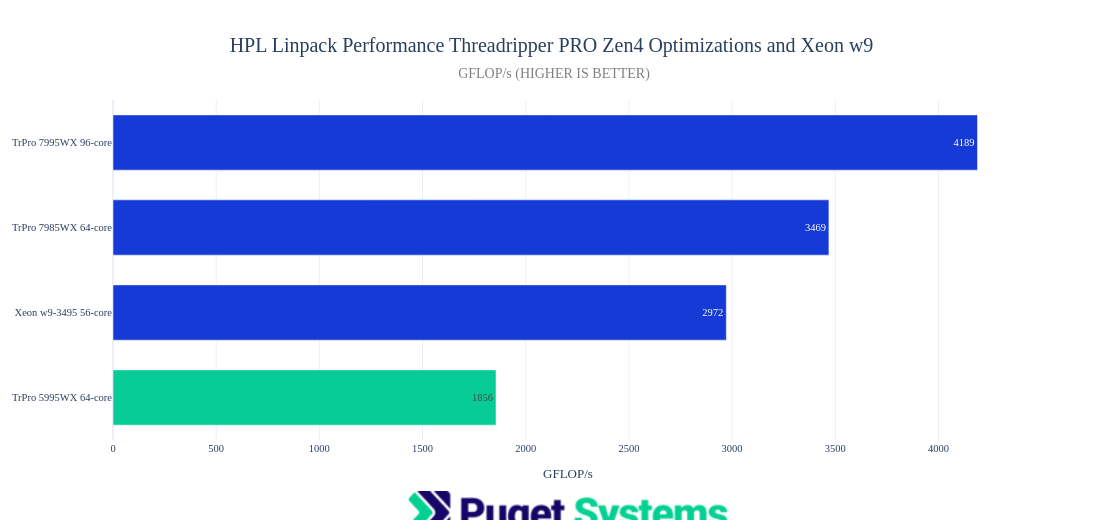

In [74]:
title="HPL Linpack Performance Threadripper PRO Zen4 Optimizations and Xeon w9"
perf_unit="<br> <span style='color:grey;font-size: 14px'>GFLOP/s (HIGHER IS BETTER)</span>"
xtitle="GFLOP/s"

x = dfhpl["GFLOP/s"]
y = dfhpl["CPU"]
try:
    plot_bar(x,y,title,perf_unit,xtitle)
except Exception as e:
    print(e)

In [56]:
dfhplmxp = pd.DataFrame({'CPU':[
    'TrPro 7995WX 96-core',
    'TrPro 7985WX 64-core',
    'Tr 7980X 64-core',
    'Xeon w9-3495 56-core',
     ], 
    'GFLOP/s':[17158, 13828, 13725, 38372 ]})
dfhplmxp

,CPU,GFLOP/s
0,TrPro 7995WX 96-core,17158
1,TrPro 7985WX 64-core,13828
2,Tr 7980X 64-core,13725
3,Xeon w9-3495 56-core,38372


In [58]:
def plot_bar(x,y,title,perf_unit,xtitle):
    fig = go.Figure()


    p_blue='#163AD6'
    p_green='#08CC96'
    p_lblue='#3E7AFF'
    colors=[p_blue,p_blue,p_blue,p_green]
    
    marker_color=colors

    fig.add_trace( go.Bar(
        x=x, y=y, orientation='h',
        text=x, textposition="auto",
        marker_color=colors,
        #width=.4
                )
    )

    fig.update_layout(
        title=dict(
            text=f"{title}{perf_unit}" ,
            x=0.5,y=0.90,
            xanchor='center',
            yanchor='top',
            font=dict(size=20),
            font_family="Poppins",
        ),
        bargap=0.35,
        font_family="Roboto",
        font_size=10.5,
        xaxis=dict(title=xtitle),
        #yaxis={'catagoryorder':'title:assending'},
        yaxis={'categoryorder':'array', 'categoryarray':[ 'Tr 7980X 64-core','TrPro 7985WX 64-core','TrPro 7995WX 96-core']},
        template="plotly_white",

        autosize=True,
        width=800,
        height=520,

    )

    fig.add_layout_image(
        dict(
            source=img, # "./PugetSystems_Logo_RGB_1.resized.png"
            xref="paper", yref="paper",
            x=0.5, y=-.15,
            sizex=0.35, sizey=0.35,
            xanchor="center", yanchor="top"
            )
    )

    fig.show()

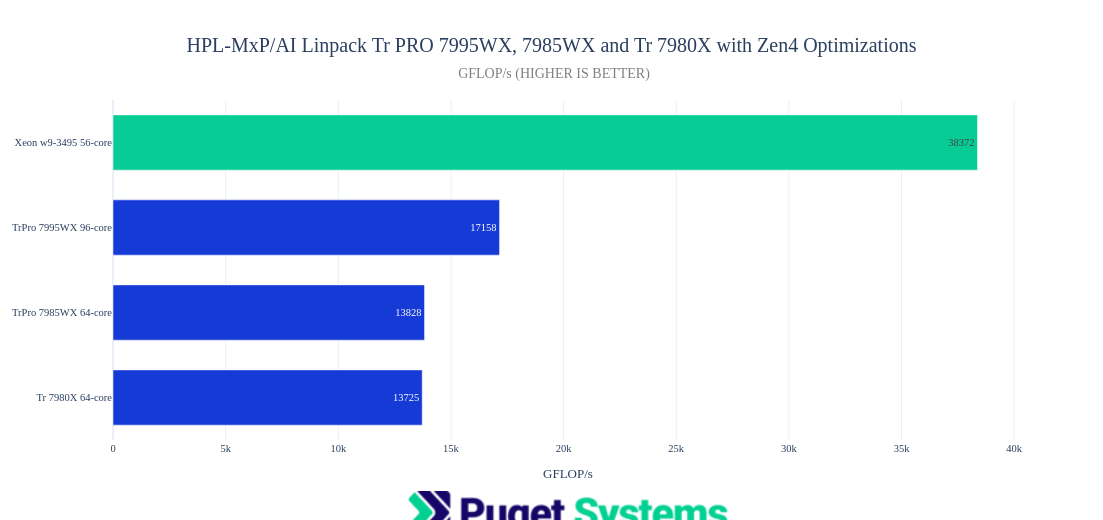

In [61]:
title="HPL-MxP/AI Linpack Tr PRO 7995WX, 7985WX and Tr 7980X with Zen4 Optimizations"
perf_unit="<br> <span style='color:grey;font-size: 14px'>GFLOP/s (HIGHER IS BETTER)</span>"
xtitle="GFLOP/s"

x = dfhplmxp["GFLOP/s"]
y = dfhplmxp["CPU"]

plot_bar(x,y,title,perf_unit,xtitle)

In [66]:
dfhpcg = pd.DataFrame({'CPU':[
    'TrPro 7995WX 96-core',
    'TrPro 7985WX 64-core',
    'Tr 7980X 64-core',
    'Xeon w9-3495 56-core',
    'TrPro 5995WX 64-core',
     ], 
    'GFLOP/s':[47.1, 47.1, 26.62, 46.8, 19 ]})
dfhpcg

,CPU,GFLOP/s
0,TrPro 7995WX 96-core,47.10
1,TrPro 7985WX 64-core,47.10
2,Tr 7980X 64-core,26.62
3,Xeon w9-3495 56-core,46.80
4,TrPro 5995WX 64-core,19.00


In [67]:
def plot_bar(x,y,title,perf_unit,xtitle):
    fig = go.Figure()


    p_blue='#163AD6'
    p_green='#08CC96'
    p_lblue='#3E7AFF'
    colors=[p_blue,p_blue,p_blue,p_green,p_lblue]
    
    marker_color=colors

    fig.add_trace( go.Bar(
        x=x, y=y, orientation='h',
        text=x, textposition="auto",
        marker_color=colors,
        #width=.4
                )
    )

    fig.update_layout(
        title=dict(
            text=f"{title}{perf_unit}" ,
            x=0.5,y=0.90,
            xanchor='center',
            yanchor='top',
            font=dict(size=20),
            font_family="Poppins",
        ),
        bargap=0.35,
        font_family="Roboto",
        font_size=10.5,
        xaxis=dict(title=xtitle),
        #yaxis={'catagoryorder':'title:assending'},
        yaxis={'categoryorder':'array', 'categoryarray':[ 'TrPro 5995WX 64-core','Tr 7980X 64-core','Xeon w9-3495 56-core','TrPro 7985WX 64-core','TrPro 7995WX 96-core',]},
        template="plotly_white",

        autosize=True,
        width=800,
        height=520,

    )

    fig.add_layout_image(
        dict(
            source=img, #"./PugetSystems_Logo_RGB_1.resized.png",
            xref="paper", yref="paper",
            x=0.5, y=-.15,
            sizex=0.35, sizey=0.35,
            xanchor="center", yanchor="top"
            )
    )

    fig.show()

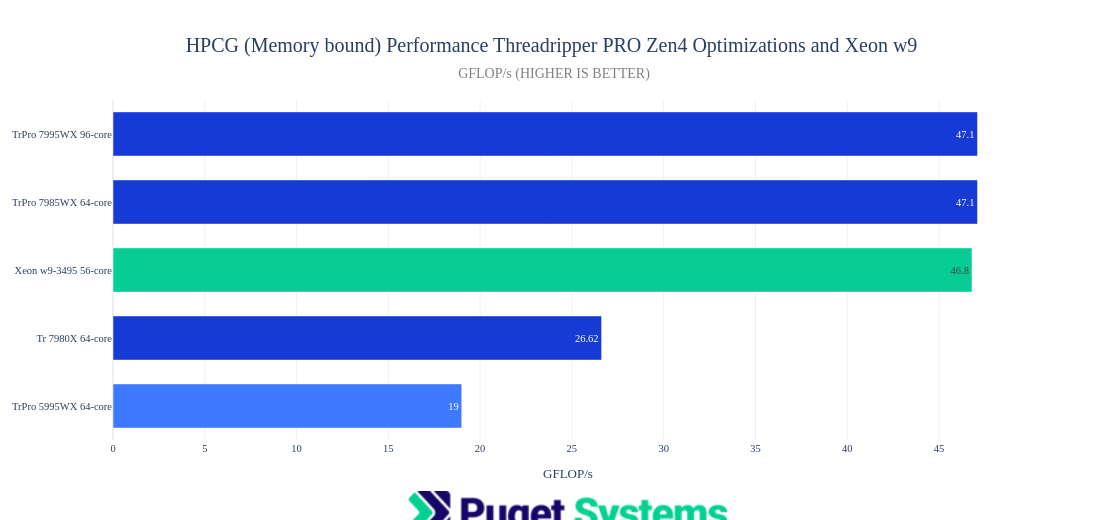

In [68]:
title="HPCG (Memory bound) Performance Threadripper PRO Zen4 Optimizations and Xeon w9"
perf_unit="<br> <span style='color:grey;font-size: 14px'>GFLOP/s (HIGHER IS BETTER)</span>"
xtitle="GFLOP/s"

x = dfhpcg["GFLOP/s"]
y = dfhpcg["CPU"]

plot_bar(x,y,title,perf_unit,xtitle)

In [69]:
dfof = pd.DataFrame({'CPU':[
    'TrPro 7995WX 96-core',
    'TrPro 7985WX 64-core',
    'Tr 7980X 64-core',
    'Xeon w9-3495 56-core',
    'TrPro 5995WX 64-core',
     ], 
    'sec':[12.92, 15.64, 24.57, 34.2, 39.5 ]})
dfof

,CPU,sec
0,TrPro 7995WX 96-core,12.92
1,TrPro 7985WX 64-core,15.64
2,Tr 7980X 64-core,24.57
3,Xeon w9-3495 56-core,34.20
4,TrPro 5995WX 64-core,39.50


In [70]:
def plot_bar(x,y,title,perf_unit,xtitle):
    fig = go.Figure()


    p_blue='#163AD6'
    p_green='#08CC96'
    p_lblue='#3E7AFF'
    colors=[p_blue,p_blue,p_blue,p_green,p_lblue]
    
    marker_color=colors

    fig.add_trace( go.Bar(
        x=x, y=y, orientation='h',
        text=x, textposition="auto",
        marker_color=colors,
        #width=.4
                )
    )

    fig.update_layout(
        title=dict(
            text=f"{title}{perf_unit}" ,
            x=0.5,y=0.90,
            xanchor='center',
            yanchor='top',
            font=dict(size=20),
            font_family="Poppins",
        ),
        bargap=0.35,
        font_family="Roboto",
        font_size=10.5,
        xaxis=dict(title=xtitle),
        #yaxis={'catagoryorder':'title:assending'},
        yaxis={'categoryorder':'array', 'categoryarray':[ 'TrPro 5995WX 64-core','Xeon w9-3495 56-core','Tr 7980X 64-core','TrPro 7985WX 64-core','TrPro 7995WX 96-core',]},
        template="plotly_white",

        autosize=True,
        width=800,
        height=520,

    )

    fig.add_layout_image(
        dict(
            source=img, #"./PugetSystems_Logo_RGB_1.resized.png",
            xref="paper", yref="paper",
            x=0.5, y=-.15,
            sizex=0.35, sizey=0.35,
            xanchor="center", yanchor="top"
            )
    )

    fig.show()

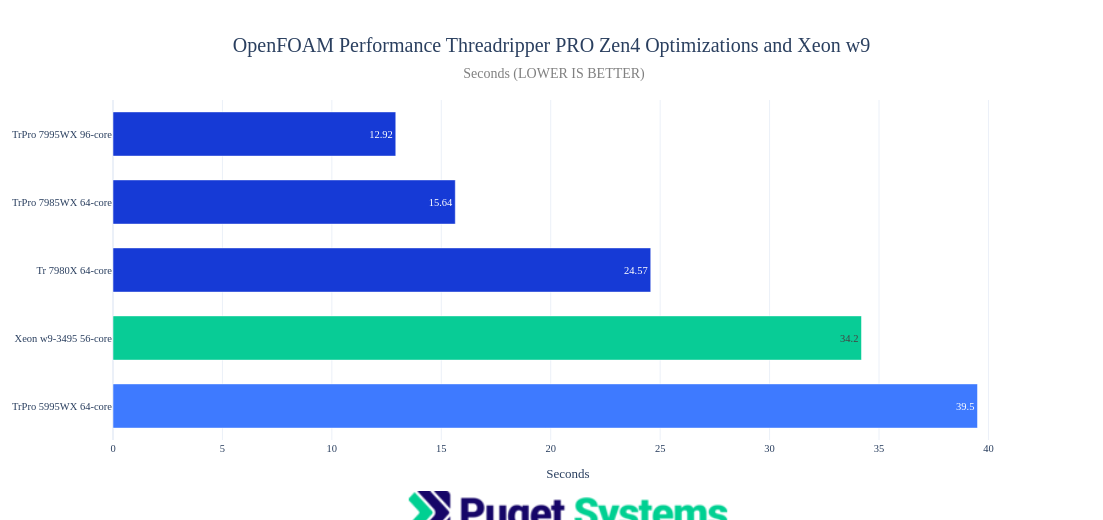

In [71]:
title="OpenFOAM Performance Threadripper PRO Zen4 Optimizations and Xeon w9"
perf_unit="<br> <span style='color:grey;font-size: 14px'>Seconds (LOWER IS BETTER)</span>"
xtitle="Seconds"

x = dfof["sec"]
y = dfof["CPU"]

plot_bar(x,y,title,perf_unit,xtitle)

## OpenFOAM Scaling

In [31]:
# These are the run times
of7995 = np.array([474.85,247.87,163.12,138.43,66.2,41.08,29.67,19.99,17.98,16.31,14.26,12.92])
of7995 = of7995[0]/of7995
print(of7995)

of7985 = np.array([472.78,240.1,144.32,116.84,56.15,34.5,25.64,18.97,15.64])
of7985 = of7985[0]/of7985
print(of7985)

of3495 = np.array([536.25,264.46,133.13,70.9,41.8,33.43,29.39,26.52,24.72,23.2])
of3495 = of3495[0]/of3495
print(of3495)

of7980 = np.array([480.57,237.14,144.83,116.98,59.5,43.41,37.2,28.8,24.57])
of7980 = of7980[0]/of7980
print(of7980)

[ 1.          1.91572195  2.91104708  3.43025356  7.17296073 11.55915287
 16.00438153 23.75437719 26.40989989 29.11404047 33.29943899 36.75309598]
[ 1.          1.96909621  3.27591463  4.04638822  8.41994657 13.70376812
 18.43915757 24.92250923 30.22890026]
[ 1.          2.02771686  4.02801773  7.56346968 12.82894737 16.04098115
 18.24600204 20.22058824 21.69296117 23.11422414]
[ 1.          2.02652442  3.31816613  4.10813814  8.07680672 11.07049067
 12.91854839 16.68645833 19.55921856]


In [32]:
ncores7995 = np.array([1,2,4,8,16,24,32,48,56,64,80,96])
ncores7985 = np.array([1,2,4,8,16,24,32,48,64])
ncores3495 = np.array([1,2,4,8,16,24,32,40,48,56])
ncores7980 = np.array([1,2,4,8,16,24,32,48,64])

In [33]:
popt7995, pcov = curve_fit(lambda n,P: amdhal(n,P,of7995[0]), ncores7995, of7995)
print(popt7995)

popt7985, pcov = curve_fit(lambda n,P: amdhal(n,P,of7985[0]), ncores7985, of7985)
print(popt7985)

popt3495, pcov = curve_fit(lambda n,P: amdhal(n,P,of3495[0]), ncores3495, of3495)
print(popt3495)

popt7980, pcov = curve_fit(lambda n,P: amdhal(n,P,of7980[0]), ncores7980, of7980)
print(popt7980)


[0.98065073]
[0.97976373]
[0.9749843]
[0.95879776]


(20,)


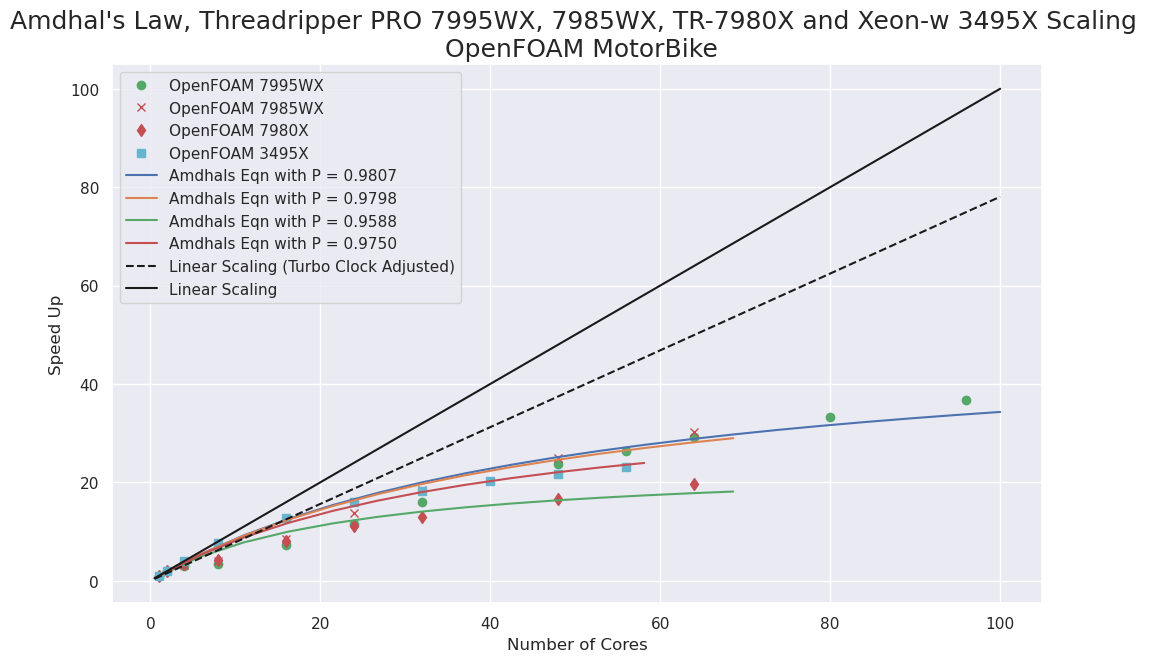

In [38]:
plt.rcParams["figure.figsize"] = [12,7]
#plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
ax.plot( ncores7995, of7995, "o", color='g', label='OpenFOAM 7995WX')  # plot the test data
ax.plot( ncores7985, of7985, "x", color='r', label='OpenFOAM 7985WX')
ax.plot( ncores7980, of7980, "d", color='r', label='OpenFOAM 7980X') 
ax.plot( ncores3495, of3495, "s", color='c', label='OpenFOAM 3495X') 

xt = np.linspace(0.5,100,20)
print(xt.shape)

ax.plot(xt, amdhal(xt,popt7995,of7995[0])  ,  label='Amdhals Eqn with P = %.4f ' %(popt7995[0]))  # plot the model function
ax.plot(xt[:14], amdhal(xt[:14],popt7985,of7985[0])  ,  label='Amdhals Eqn with P = %.4f ' %(popt7985[0]))
ax.plot(xt[:14], amdhal(xt[:14],popt7980,of7980[0])  ,  label='Amdhals Eqn with P = %.4f ' %(popt7980[0]))
ax.plot(xt[:12], amdhal(xt[:12],popt3495,of3495[0])  ,  label='Amdhals Eqn with P = %.4f ' %(popt3495[0]))


slope=3.2/4.1
ax.plot(xt,slope*xt, "--", color='k', label='Linear Scaling (Turbo Clock Adjusted)')
ax.plot(xt,of7995[0]*xt, color='k', label='Linear Scaling')

plt.xlabel("Number of Cores")
plt.ylabel("Speed Up")
plt.title("Amdhal's Law, Threadripper PRO 7995WX, 7985WX, TR-7980X and Xeon-w 3495X Scaling \n OpenFOAM MotorBike", fontsize=18)
ax.legend()

fig.savefig('openfoal-scale.png')